# **Kode Program Klasifikasi Gambar + Sistem Parkir**

**1. 🔼 Panggil Dataset dari Google Drive**

*   Mount Google Drive
*   Copy File dari Gdrive ke lokal Colab
*   Ekstrak ZIP ke folder lokal Colab






In [10]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
# Copy file ZIP dari Google Drive ke lokal Colab
import shutil

zip_source = "/content/drive/MyDrive/Dataset & Google Colab UAS SC/Parkir Jenis Kendaraan (2).zip"
zip_dest = "/content/dataset_kendaraan.zip"

shutil.copy(zip_source, zip_dest)

'/content/dataset_kendaraan.zip'

In [21]:
# Ekstrak ZIP ke folder lokal Colab
import zipfile, os

extract_path = "/content/dataset_kendaraan"
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_dest, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Ekstraksi selesai. Isi folder:")
print(os.listdir(extract_path))


✅ Ekstraksi selesai. Isi folder:
['Parkir Jenis Kendaraan']


**2. 🧹 Preprocessing Data (Augmentasi + Normalisasi)**

*   Data Cleaning
*   Ukuran gambar model
*   Objek ImageDataGenerator
*   Data training
*   Data validation





In [22]:
import os
from PIL import Image

# Fungsi untuk menghapus gambar yang rusak atau terpotong (truncated)
def delete_truncated_images(directory):
    count_deleted = 0
    print(f"🔎 Memulai pengecekan dan penghapusan gambar rusak di: {directory}")

    # Iterasi melalui semua file di direktori dan subdirektorinya
    for root, _, files in os.walk(directory):
        for file in files:
            # Periksa apakah file adalah gambar (jpg, jpeg, png)
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                filepath = os.path.join(root, file)
                try:
                    # Buka dan muat gambar untuk mendeteksi kerusakan
                    with Image.open(filepath) as img:
                        img.load()
                except (IOError, SyntaxError) as e:
                    # Jika gambar rusak, hapus file tersebut
                    print(f"Menghapus gambar rusak: {filepath} - Error: {e}")
                    try:
                        os.remove(filepath)
                        count_deleted += 1
                    except OSError as remove_error:
                        print(f"Error removing file {filepath}: {remove_error}")

    # Laporkan hasil penghapusan gambar
    if count_deleted == 0:
        print("✅ Tidak ada gambar rusak yang ditemukan.")
    else:
        print(f"🗑️ Total gambar rusak yang dihapus: {count_deleted}")

# Panggil fungsi pembersihan untuk direktori dataset kendaraan
dataset_directory = 'dataset_kendaraan/Parkir Jenis Kendaraan/Vehicles' # Path disesuaikan
delete_truncated_images(dataset_directory)

🔎 Memulai pengecekan dan penghapusan gambar rusak di: dataset_kendaraan/Parkir Jenis Kendaraan/Vehicles
Menghapus gambar rusak: dataset_kendaraan/Parkir Jenis Kendaraan/Vehicles/Truck/Datacluster Truck (123).jpg - Error: image file is truncated (8 bytes not processed)
🗑️ Total gambar rusak yang dihapus: 1


**Augmentasi Data**

In [40]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Menentukan ukuran gambar yang digunakan oleh model dan ukuran batch
image_size = (224, 224)
batch_size = 32

# Path ke folder dataset
dataset_path = "/content/dataset_kendaraan/Parkir Jenis Kendaraan/Vehicles"

# Membuat objek ImageDataGenerator untuk preprocessing dan augmentasi data
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2,
    fill_mode='nearest'
)

# Membuat generator data training dari folder 'Vehicles'
train_data = datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Membuat generator data validasi dari folder 'Vehicles'
val_data = datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 1720 images belonging to 5 classes.
Found 429 images belonging to 5 classes.


**3. 🧠 Transfer Learning dengan MobileNetV2**

*   MobileNet2 (Pretrained Model)
*   Fine-Tuning (Layer Tambahan)
*   Kompilasi Model





In [48]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Load base model MobileNetV2 tanpa top (fully connected layer)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze layer bawaan agar cepat convergence

# Tambahkan custom classification layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_data.num_classes, activation='softmax')(x)

# Buat model akhir
model = Model(inputs=base_model.input, outputs=predictions)

# Compile
model.compile(optimizer=Adam(learning_rate=0.0006), loss='categorical_crossentropy', metrics=['accuracy'])

# Early Stopping
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

# Learning Rate Scheduler
lr_schedule = ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,          # Turunkan lr rate if val_loss tidak membaik
    factor=0.2,          # Learning rate dikalikan 0.2
    min_lr=1e-6          # Batas bawah learning rate
)

**4. 🏋️‍♀️ Training Model**

In [49]:
# Training ulang dengan model yang lebih kuat
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=30,
    callbacks=[early_stop, lr_schedule]
)

Epoch 1/30
 8/54 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - accuracy: 0.2411 - loss: 2.0154

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


54/54 ━━━━━━━━━━━━━━━━━━━━ 157s 3s/step - accuracy: 0.5653 - loss: 1.1525 - val_accuracy: 0.9161 - val_loss: 0.2575 - learning_rate: 6.0000e-04
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 0.8308 - loss: 0.4127 - val_accuracy: 0.9161 - val_loss: 0.2295 - learning_rate: 6.0000e-04
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 145s 3s/step - accuracy: 0.8784 - loss: 0.3249 - val_accuracy: 0.9371 - val_loss: 0.1838 - learning_rate: 6.0000e-04
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 152s 3s/step - accuracy: 0.9097 - loss: 0.2607 - val_accuracy: 0.9417 - val_loss: 0.1634 - learning_rate: 6.0000e-04
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 0.9008 - loss: 0.2549 - val_accuracy: 0.9044 - val_loss: 0.2147 - learning_rate: 6.0000e-04
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 150s 3s/step - accuracy: 0.9222 - loss: 0.2414 - val_accuracy: 0.9207 - val_loss: 0.2014 - learning_rate: 6.0000e-04
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 146s 3s/step - accuracy: 0.9205 - loss: 0.2

**5. 📊 Evaluasi Model**

*   Prediksi data validasi
*   Confusion Matrix
*   Classification Report
*   Accuracy Score



14/14 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step


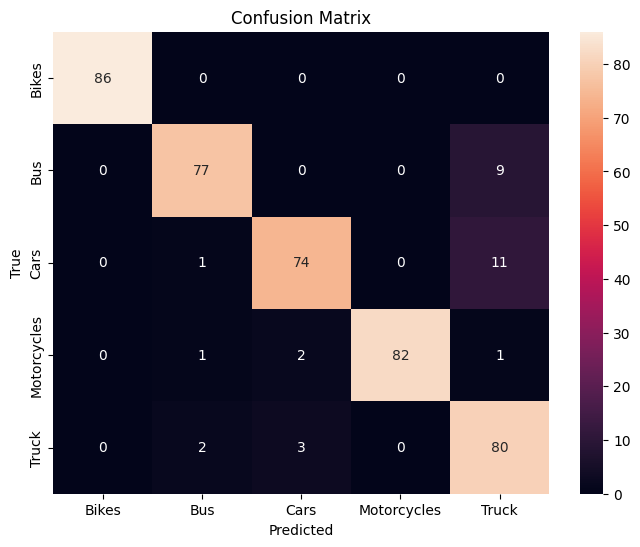

              precision    recall  f1-score   support

       Bikes       1.00      1.00      1.00        86
         Bus       0.95      0.90      0.92        86
        Cars       0.94      0.86      0.90        86
 Motorcycles       1.00      0.95      0.98        86
       Truck       0.79      0.94      0.86        85

    accuracy                           0.93       429
   macro avg       0.94      0.93      0.93       429
weighted avg       0.94      0.93      0.93       429

Accuracy Score: 93.01%


In [50]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Prediksi di data validasi
Y_pred = model.predict(val_data)
y_pred = np.argmax(Y_pred, axis=1)

# Tampilkan Confusion Matrix
cm = confusion_matrix(val_data.classes, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=val_data.class_indices.keys(), yticklabels=val_data.class_indices.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification Report
print(classification_report(val_data.classes, y_pred, target_names=val_data.class_indices.keys()))

# Accuracy Score
accuracy = accuracy_score(val_data.classes, y_pred)
print(f"Accuracy Score: {accuracy * 100:.2f}%")

**6. 🖼 Upload Gambar Kendaraan untuk Diuji**

In [1]:
# Uji Parkir dengan Upload Gambar Kendaraan
from tensorflow.keras.preprocessing import image
uploaded = files.upload()

NameError: name 'files' is not defined

**7. 🅿️ Deteksi Kendaraan + Simulasi Parkir Realistis**

*   Deteksi gambar kendaraan
*   Tampilkan informasi parkir kendaraan
*   Simulasi parkir kendaraan dan pembayaran
*   Logging Data ke file CSV


In [47]:
import pandas as pd
from datetime import datetime
import os
from tensorflow.keras.preprocessing import image
import numpy as np
from google.colab import files # Assuming files was imported in a previous cell

#Info parkir berdasarkan jenis kendaraan
info_parkir = {
    'Bus': {"tarif": 15000, "lantai": "1 & 2", "area": "C1–C4 & B1–B6"},
    'Cars': {"tarif": 8000, "lantai": "2 & 3", "area": "B7–A10 & A1–A6"},
    'Truck': {"tarif": 10000, "lantai": "1", "area": "C5–C8"},
    'Bikes': {"tarif": 1000, "lantai": "1", "area": "C9–C10"},
    'Motorcycles': {"tarif": 3000, "lantai": "B1 & B2", "area": "D1–D10 & E1–E10"}
}

#Deteksi gambar kendaraan & tampilkan informasi parkir
for fn in uploaded.keys():

    # Preprocessing gambar
    img = image.load_img(fn, target_size=image_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Prediksi jenis kendaraan
    prediction = model.predict(img_array)
    class_index = np.argmax(prediction)
    class_label = list(train_data.class_indices.keys())[class_index]

    # Tampilkan info hasil deteksi
    print(f"\n🔍 Jenis Kendaraan Terdeteksi: {class_label}")
    print(f"📍 Lantai: {info_parkir[class_label]['lantai']}")
    print(f"📍 Area: {info_parkir[class_label]['area']}")
    print(f"💰 Tarif Parkir: Rp{info_parkir[class_label]['tarif']}/jam")

    # Input waktu masuk & keluar
    tanggal_masuk = input("📅 Masukkan tanggal masuk (format: YYYY-MM-DD): ")
    jam_masuk = input("⏱ Masukkan waktu masuk (format: HH:MM, contoh: 08:00): ")

    tanggal_keluar = input("📅 Masukkan tanggal keluar (format: YYYY-MM-DD): ")
    jam_keluar = input("⏱ Masukkan waktu keluar (format: HH:MM, contoh: 10:15): ")

    # Hitung durasi (dalam jam)
    t1 = datetime.strptime(f"{tanggal_masuk} {jam_masuk}", "%Y-%m-%d %H:%M")
    t2 = datetime.strptime(f"{tanggal_keluar} {jam_keluar}", "%Y-%m-%d %H:%M")
    # Call the total_seconds method by adding ()
    durasi = (t2 - t1).total_seconds() / 3600
    durasi_jam = max(1, round(durasi))  # dibulatkan ke atas min 1 jam

    # Hitung total tarif parkir
    tarif_per_jam = info_parkir[class_label]['tarif']
    total = tarif_per_jam * durasi_jam

    # Output durasi & biaya parkir
    print(f"🕓 Durasi Parkir: {durasi_jam} jam")
    print(f"💸 Total Tarif: Rp{total}")

    # Proses pembayaran
    bayar = int(input("💵 Masukkan jumlah uang yang dibayar (misal 20000): "))
    kembali = bayar - total
    print(f"💳 Kembalian: Rp{kembali}")

    # Buat log dictionary ke CSV harian
    log_data = {
        "tanggal_masuk": tanggal_masuk,
        "jam_masuk": jam_masuk,
        "tanggal_keluar": tanggal_keluar,
        "jam_keluar": jam_keluar,
        "kendaraan": class_label,
        "durasi_jam": durasi_jam,
        "total_tarif": total,
        "dibayar": bayar,
        "kembalian": kembali,
        "waktu_input": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    }
    # Konversi ke DataFrame
    df_log = pd.DataFrame([log_data])

    # Buat nama file berdasarkan tanggal masuk
    # Corrected: use 'tanggal_masuk' from log_data instead of 'tanggal'
    log_filename = f"log_parkir_{log_data['tanggal_masuk']}.csv"

    # Simpan ke file log harian
    df_log.to_csv(log_filename, mode='a', header=not os.path.exists(log_filename), index=False)

    print(f"📝 Data parkir disimpan ke {log_filename}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

🔍 Jenis Kendaraan Terdeteksi: Cars
📍 Lantai: 2 & 3
📍 Area: B7–A10 & A1–A6
💰 Tarif Parkir: Rp8000/jam
📅 Masukkan tanggal masuk (format: YYYY-MM-DD): 2025-06-10
⏱ Masukkan waktu masuk (format: HH:MM, contoh: 08:00): 10:37
📅 Masukkan tanggal keluar (format: YYYY-MM-DD): 2025-06-10
⏱ Masukkan waktu keluar (format: HH:MM, contoh: 10:15): 16:57
🕓 Durasi Parkir: 6 jam
💸 Total Tarif: Rp48000
💵 Masukkan jumlah uang yang dibayar (misal 20000): 50000
💳 Kembalian: Rp2000
📝 Data parkir disimpan ke log_parkir_2025-06-10.csv
